# Surface temperature over time and TOA radiation

Figure 1

Last modified March 3 2025 to include ocean heat content

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm.notebook import tqdm

In [13]:
# find files that start with a certain pattern
def find_files(directory,start_str):
    import os
    files = [f for f in os.listdir(directory) if f.startswith(start_str)]

    # If you want to handle only the first matching file
    if files:
        matching_file = files[-1]
        #print(f"Found file: {matching_file}")
        return matching_file
    else:
        print(f"No file found {directory, start_str}.")
        return None

In [14]:
def get_experiment_names(model):
    if model == 'FLOR':
        extension = 'tigercpu_intelmpi_18_576PE'
        exps = ['p6p0sol_CTL1860',
                'p4p0sol_CTL1860',
                'p2p0sol_CTL1860', 
                'p1p0sol_CTL1860',
                'CTL1860_newdiag',
                'm1p0sol_CTL1860', 
                'm2p0sol_CTL1860',
                'm4p0sol_CTL1860',
                'm6p0sol_CTL1860',]
        modelstr = 'FLOR'

    if model == 'CM2.1p1':
        extension = 'tigercpu_intelmpi_18_80PE'
        exps = ['CTL1860_p6pctSolar', 
                'CTL1860_p4pctSolar',
                'CTL1860_p2pctSolar',
                'CTL1860_p1pctSolar', 
                'CTL1860',
                'CTL1860_m1pctSolar',
                'CTL1860_m2pctSolar',
                'CTL1860_m4pctSolar',
                'CTL1860_m6pctSolar',
                ]
        modelstr = 'CM2.1'
    return exps, extension, modelstr

In [15]:
# load and plot all the experiments

plt.style.use('../func/paper.mplstyle')

modelnames = ['FLOR','CM2.1p1']
modelstr = ['FLOR','CM2.1']

labels = [
          '+6%',
          '+4%',
          '+2%',
          '+1%',
          'CTRL',
          '-1%',
          '-2%',
          '-4%',
          '-6%',
        ]
colors = [
         'darkred',
         'red',
         'orange',
         'gold',
        'grey',
         'cyan',
         'dodgerblue',
         'blue',
         'darkblue',
        ]

In [16]:
def get_label(var):   
    if var == 'netrad_toa':
        label = 'Global mean net TOA radiation [W m$^{-2}$]'
    if var == 't_ref':
        label = 'Global mean surface temperature [K]'
    if var == 'total_ocean_heat_ts':
        label = r'Total ocean heat (ref: $0^{\circ}$C) [J$\times 10^{-25}$]'
    return label

# plot with OHU and star crashes

In [17]:
def get_crash_coords(xdata, ydata, crash_year=-1, 
               window_yr=10):
    # note that the input data is often smoothed, so we have to plot at the closest central time
    # default: monthly data is smoothed with 10-year smoothing window
    # output: x and y coordinates for the crash to plot

    if crash_year == -1: # last year
        x_crash = xdata[-6*window_yr]
        y_crash = ydata[-6*window_yr]

    else: # if the crash year is any other year
        x_crash = xdata[crash_year*12]
        y_crash = ydata[crash_year*12]

    return x_crash, y_crash

# Implementation
# if (modelnames[ii] == 'FLOR' and (labels[iexp] == '-4%' or labels[iexp] == '-6%')) or (modelnames[ii] == 'CM2.1p1' and labels[iexp] == 
#                                                                     '+6%' or labels[iexp] == '-6%'):
#     #print(f'{modelnames[ii]} {labels[iexp]} crashed')
#     x_crash, y_crash = get_crash_coords(x, y, crash_year=-1)
#     ax[0,ii].scatter(x_crash, y_crash,
#                    marker = '*', s=100, color = 'r', zorder=10)

#     if modelnames[ii] == 'CM2.1p1' and labels[iexp] == '-6%':
#         x_crash, y_crash = get_crash_coords(x, y, crash_year=933)
#         ax[0,ii].scatter(x_crash, y_crash,
#                    marker = '*', s=100, color = 'r', zorder=10)

In [18]:
def slice_time_CTRL(data, file_name):
    # For control experiments (implemented below), slice time depending on when the file loaded starts
    if '0001' in file_name:
        return data.isel(time=slice(12 * 100, 12 * 2100))
    elif '0101' in file_name:
        return data.isel(time=slice(0, 12 * 2000))
    else:
        print(f'Error for time in file: {file_name}')
        return data

In [36]:
def myplot(xvar, yvar, ax,
           xdirin='/tigress/mvchung/ANALYSIS/Solar_NEW/global_mean/',
           ydirin='/tigress/mvchung/ANALYSIS/Solar_NEW/global_mean/',
           modelnames=['FLOR','CM2.1p1'], 
           labels = ['+6%','+4%','+2%','+1%','CTRL','-1%','-2%','-4%','-6%'], 
           colors = ['darkred','red','orange','gold','grey','cyan','dodgerblue','blue','darkblue'],
           xlim=None, ylim=None, plotlegend=True):
    
    plt.style.use('../func/paper.mplstyle')
    
    #fig, ax = plt.subplots(1,2,figsize=(10,6), sharex=True, sharey=True)

    for ii in range(np.size(modelnames)):

        # get the names of the experiments
        exps, extension, modelstr = get_experiment_names(modelnames[ii])

        for iexp in range(np.size(exps)):
            x = []
            y = []

            # Use glob to find the file with any characters after the extension
            if yvar == 'total_ocean_heat_ts':
                y_ifile = find_files(ydirin,
                                        f'{yvar}_{modelnames[ii]}_{exps[iexp]}.')
            else:
                y_ifile = find_files(ydirin,
                                       f'{yvar}_{modelnames[ii]}_{exps[iexp]}_{extension}')
            if y_ifile == None:
                continue
            y = xr.open_dataarray(f'{ydirin}{y_ifile}')

            if xvar == 'total_ocean_heat_ts':
                x_ifile = find_files(xdirin,
                                        f'{xvar}_{modelnames[ii]}_{exps[iexp]}.')
            else:
                x_ifile = find_files(xdirin,
                                        f'{xvar}_{modelnames[ii]}_{exps[iexp]}_{extension}')
            if x_ifile == None:
                continue
            x = xr.open_dataarray(f'{xdirin}{x_ifile}')

            if exps[iexp] == 'CTL1860_newdiag' or exps[iexp] == 'CTL1860': # If control experiment, only plot years 100-2100
                x = slice_time_CTRL(x, x_ifile) # see function in cell above
                y = slice_time_CTRL(y, y_ifile)
            
            if x.size != y.size:
                min_size = np.min([x.size,y.size])
                x = x.isel(time=slice(0,min_size))
                y = y.isel(time=slice(0,min_size))
            
            # get number of years
            n_yr = int(y.time.size/12)

            # get n-year rolling mean
            window_yr = 10
            x = x.rolling(time=12*window_yr, center=True).mean('time')
            y = y.rolling(time=12*window_yr, center=True).mean('time')
            
            # scatter plot
            # ax[ii].scatter(x,y,
            #                    marker = '.',s=5,
            #                    color = colors[iexp], label=f'{labels[iexp]} ({n_yr})',
            #               alpha=1)
            ax[ii].plot(x,y,color = colors[iexp], label=f'{labels[iexp]} ({n_yr})',
                          alpha=1)

            # Plot stars at end for experiments that crashed
            if (modelnames[ii] == 'FLOR' and (labels[iexp] == '-4%' or labels[iexp] == '-6%')) or (modelnames[ii] == 'CM2.1p1' and labels[iexp] == 
                                                                                '+6%' or labels[iexp] == '-6%'):
                #print(f'{modelnames[ii]} {labels[iexp]} crashed')
                x_crash, y_crash = get_crash_coords(x, y, crash_year=-1)
                ax[ii].scatter(x_crash, y_crash,
                               marker = 'x', s=100, color = 'r', zorder=10)
    
                if modelnames[ii] == 'CM2.1p1' and labels[iexp] == '-6%':
                    x_crash, y_crash = get_crash_coords(x, y, crash_year=933)
                    ax[ii].scatter(x_crash, y_crash,
                               marker = 'x', s=100, color = 'r', zorder=10)

        if plotlegend==True:
            ax[ii].legend(title='$\Delta$ Solar (# yr)',markerscale=5,fontsize=10, loc='center left') # legend
        
        if yvar == 'netrad_toa':
            ax[ii].axhline(0,color='k')
        if xvar == 'netrad_toa':
            ax[ii].avhline(0,color='k')
        ax[ii].grid(linestyle='--',zorder=0)
        #ax[ii].set_title(modelstr)
    
    xlabel = get_label(xvar)
    ylabel = get_label(yvar)

    ax[0].set_xlabel(f'{xlabel}')
    ax[1].set_xlabel(f'{xlabel}')
    #ax[0].set_ylabel('[K]')
    ax[0].set_ylabel(f'{ylabel}')
    ax[0].set_xlim(xlim)
    ax[0].set_ylim(ylim)

    

  0%|          | 0/2 [00:00<?, ?it/s]

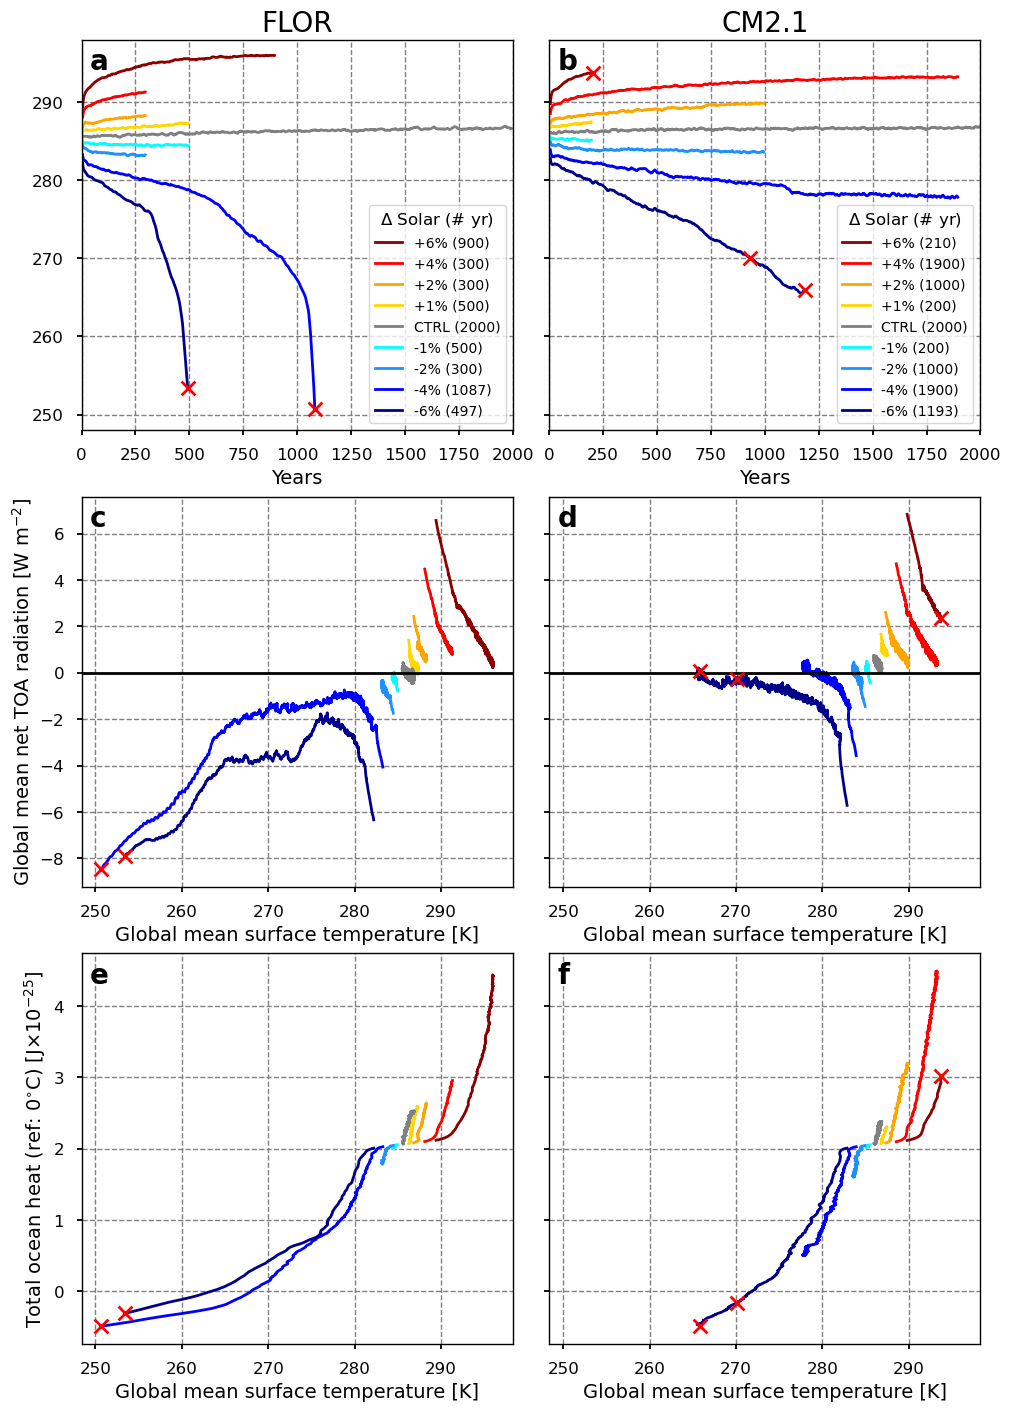

In [40]:
fig, ax = plt.subplots(3,2,figsize=(10,14), sharex='row', sharey='row')

for ii in tqdm(range(np.size(modelnames))):
    
    # ge the names of the experiments
    exps, extension, modelstr = get_experiment_names(modelnames[ii])

    for iexp in range(np.size(exps)):
        tref = []
        
        tref_ifile = find_files('/tigress/mvchung/ANALYSIS/Solar_NEW/global_mean/',
                                f't_ref_{modelnames[ii]}_{exps[iexp]}_{extension}')
        if tref_ifile == None:
            continue
        da = xr.open_dataarray(f'./global_mean/{tref_ifile}')
        
        if exps[iexp] == 'CTL1860_newdiag' or exps[iexp] == 'CTL1860': # For control experiments, only plot year 100-2100
            da = slice_time_CTRL(da, tref_ifile)
        
        # get number of years
        n_yr = int(da.time.size/12)
        
        # plot n-year rolling mean
        window_yr = 10
        y = da.rolling(time=12*window_yr, center=True).mean('time')
        x = np.arange(0,np.size(da.time)) / 12   #da.rolling(time=12*window_yr, center=True).mean('time').time
        
        ax[0,ii].plot(x,y,color=colors[iexp],label=f'{labels[iexp]} ({n_yr})', zorder=1)
        
        # Plot stars at end for experiments that crashed
        if (modelnames[ii] == 'FLOR' and (labels[iexp] == '-4%' or labels[iexp] == '-6%')) or (modelnames[ii] == 'CM2.1p1' and labels[iexp] == 
                                                                            '+6%' or labels[iexp] == '-6%'):
            #print(f'{modelnames[ii]} {labels[iexp]} crashed')
            x_crash, y_crash = get_crash_coords(x, y, crash_year=-1)
            ax[0,ii].scatter(x_crash, y_crash,
                           marker = 'x', s=100, color = 'r', zorder=10)

            if modelnames[ii] == 'CM2.1p1' and labels[iexp] == '-6%':
                x_crash, y_crash = get_crash_coords(x, y, crash_year=933)
                ax[0,ii].scatter(x_crash, y_crash,
                           marker = 'x', s=100, color = 'r', zorder=10)
        
    #ax[0,ii].legend(title='$\Delta$ Solar (# yr)',markerscale=5,fontsize=10) # legend in top subplots only
        
    ax[0,ii].grid(linestyle='--',zorder=0)
    ax[0,ii].set_title(modelstr)
    ax[0,ii].set_xlabel('Years')
    #ax[0,0].set_ylabel('[K]')
    ax[0,ii].set_xlim(0,2000)
    ax[0,ii].legend(title='$\Delta$ Solar (# yr)',markerscale=5,fontsize=10, loc='lower right')

# plot the lower subplots

# net TOA radiation
myplot(xvar='t_ref',yvar='netrad_toa', ax=ax[1,:],
      ydirin='/tigress/mvchung/ANALYSIS/Solar_NEW/global_mean/',
        xdirin='/tigress/mvchung/ANALYSIS/Solar_NEW/global_mean/',
      plotlegend=False)

# total ocean heat
myplot(xvar='t_ref',yvar='total_ocean_heat_ts', ax=ax[2,:],
      ydirin='/tigress/mvchung/ANALYSIS/Solar_NEW/processed_data/total_ocean_heat/',
      xdirin='/tigress/mvchung/ANALYSIS/Solar_NEW/global_mean/',
      plotlegend=False)

ax[0,0].set_ylim(248,298)

#fig.supylabel('Global mean surface temperature',fontsize=20)

# Add labels to each subplot
alph_labels = ['a','b','c','d','e','f']
for i, axis in enumerate(ax.flat):
    axis.text(0.02, 0.98, alph_labels[i], transform=axis.transAxes, fontsize=20, va='top', ha='left',weight='bold')
    
plt.savefig("Figure1_nonaligned.pdf", bbox_inches='tight', dpi=300)  # Prevents clipping